In [1]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from torch.optim import SGD, Adam
from torchvision import transforms
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

/Users/muhammadwaseem/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/muhammadwaseem/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <CAE66874-17C2-35C9-9C4D-6BA9770AF17F> /Users/muhammadwaseem/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <459875AA-DE2C-366B-9C44-90D4B3887080> /Users/muhammadwaseem/miniconda3/envs/torch/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


## Initialise dataset

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(size=(154, 154))])

In [3]:
class CustomDataset(Dataset):
    def __init__(self, path, transform=None, target_transform=None):
        self.transform= transform
        self.target_transform = target_transform
        self.path = path
        self.count = 0
        for i in os.listdir(self.path)[1:]: # [1:] because MacOS has .DS_Store at 0th index
            for j in os.listdir(os.path.join(self.path,i)):
                self.count += 1
        
    def __len__(self):
        return self.count
    
    def __getitem__(self, idx):
        # Lazy loading
        
        directory_idx = idx//100
        file_idx = idx%100
        
        label = directory_idx
        
        directory = os.listdir(self.path)[directory_idx + 1]
        flower_directory = os.path.join(self.path, directory)
        image_path = os.path.join(flower_directory, os.listdir(flower_directory)[file_idx])
    
        image = Image.open(image_path)
        image = transform(image)

        return image, label
        

In [4]:
dataset = CustomDataset('tiny_FR')

In [92]:
torch.manual_seed(10)
index = torch.randperm(500)

In [93]:
data_train = Subset(dataset,index[:400])
data_valid = Subset(dataset,index[400:])

In [103]:
torch.manual_seed(1)
data = DataLoader(data_train, 32, shuffle=True)
data_vl = DataLoader(data_valid, 4, shuffle=True)

## Data

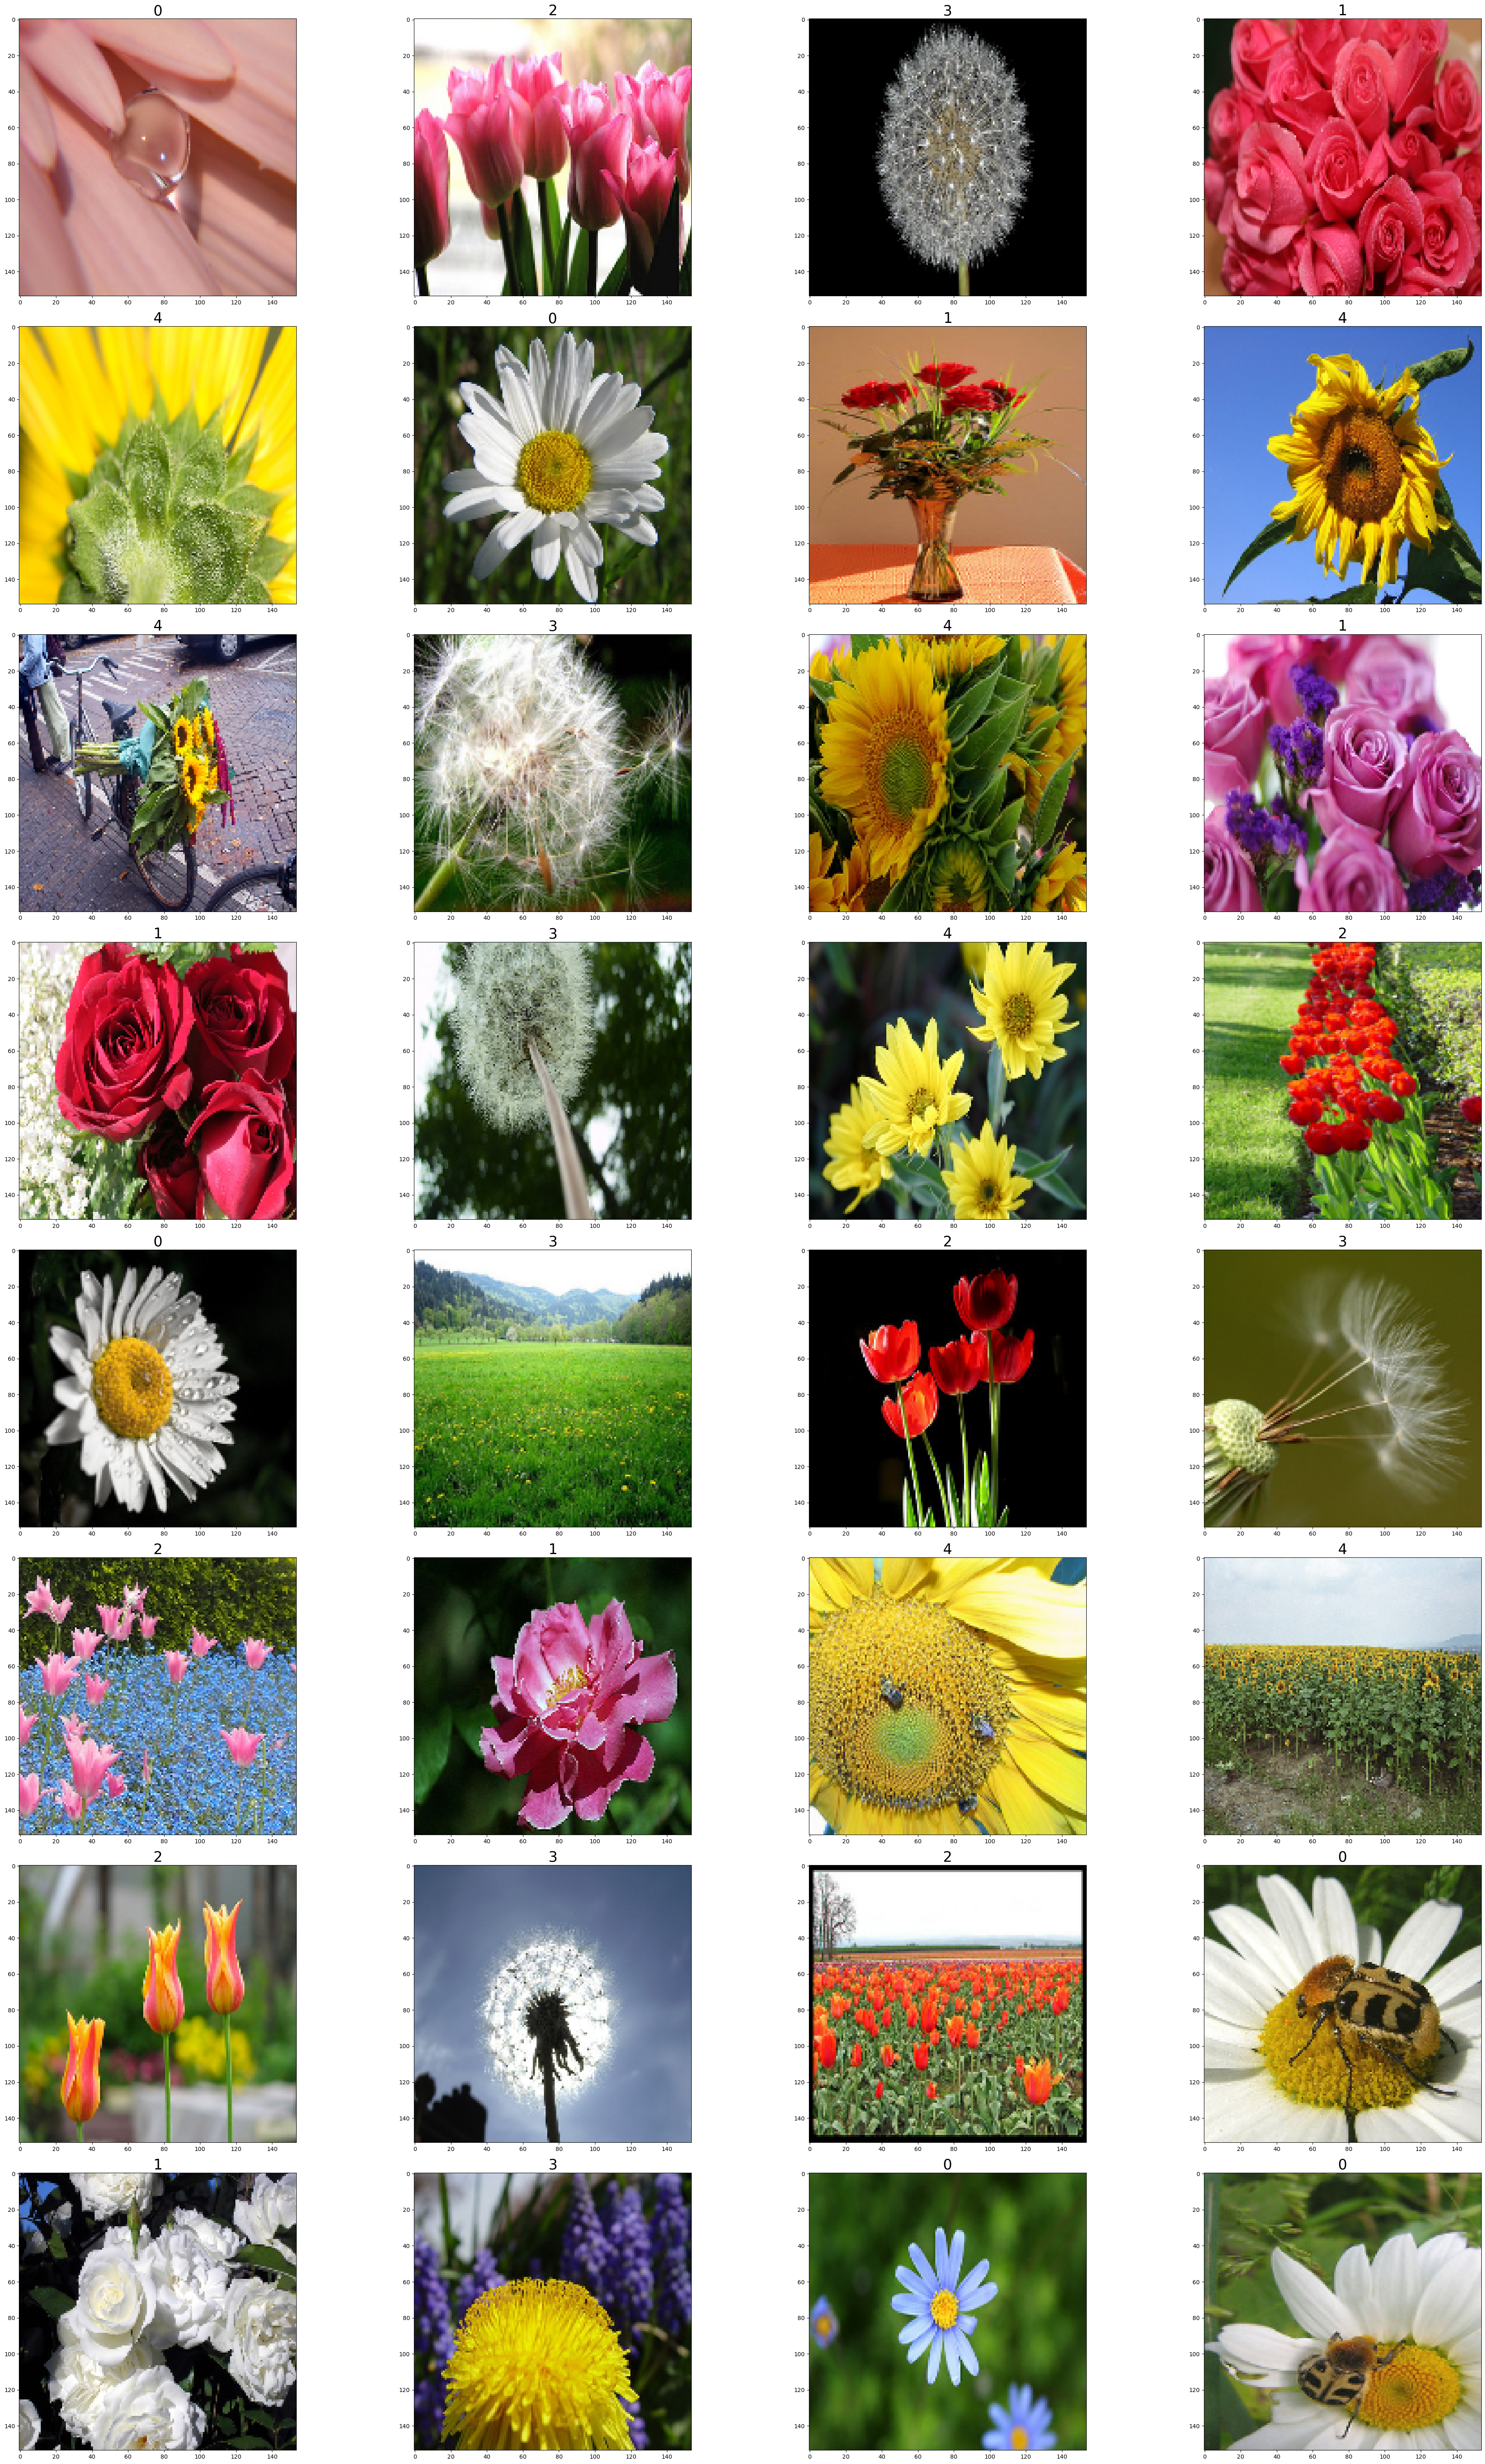

In [122]:
plt.figure(figsize=(40,60))
torch.manual_seed(1)
x,y = next(iter(data))
for i in range(32):
    plt.subplot(8,4,i+1)
    plt.title(y[i].item(), size=25)
    plt.imshow(x[i].permute(1,2,0))
plt.tight_layout()

## Model

In [123]:
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=0))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('conv2', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('conv3', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))
model.add_module('relu4', nn.ReLU())
model.add_module('pool4', nn.AvgPool2d(kernel_size=19))
model.add_module('flatten', nn.Flatten(1))
model.add_module('fc1', nn.Linear(in_features=256, out_features=64))
model.add_module('relu5', nn.ReLU())
model.add_module('fc2', nn.Linear(in_features=64, out_features=5))
model

Sequential(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=19, stride=19, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=64, out_features=5, bias=True)
)

In [124]:
dd = torch.ones(size=(16,3, 154, 154)).to(torch.float32)
dd.shape

torch.Size([16, 3, 154, 154])

In [125]:
model(dd).shape

torch.Size([16, 5])

In [126]:
loss_fn = nn.CrossEntropyLoss() 
optimizer = Adam(model.parameters(), lr=0.3)

## Train loop

In [127]:
def train(epoch, data, data_vl):
    train_loss = [0] * epoch
    train_accuracy = [0] * epoch
    valid_loss = [0] * epoch
    valid_accuracy = [0] * epoch
    for i in range(epoch):
        for x_batch, y_batch in data:
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss[i] += loss.item() * x_batch.size(0)
            softmax_pred = torch.softmax(pred, axis=1)
            #print((softmax_pred))
            is_crt = (torch.argmax(softmax_pred, axis=1) == y_batch).sum()
            train_accuracy[i] += is_crt.item()
            #print(is_crt)
        #print(train_accuracy[i])
        train_loss[i] /= len(data.dataset)
        train_accuracy[i] /= len(data.dataset)
        
        with torch.no_grad():
            for x_batch, y_batch in data_vl:
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                valid_loss[i] += loss.item() * x_batch.size(0)
                softmax_pred = torch.softmax(pred, axis=1)
                is_crt = (torch.argmax(softmax_pred, axis=1) == y_batch).sum()
                valid_accuracy[i] += is_crt
            valid_loss[i] /= len(data.dataset)
            valid_accuracy[i] /= len(data.dataset)
        print(f'Epoch {i+1} accuracy: {train_accuracy[i]:.4f} val_accuracy:{valid_accuracy[i]:.4f}')
        print(f'Epoch {i+1} loss: {train_loss[i]:.4f} val_loss:{valid_loss[i]:.4f}')
        print()
    return train_loss, train_accuracy, valid_loss, valid_accuracy

In [ ]:
epoch = 20
train_loss, train_accuracy, valid_loss, valid_accuracy = train(20, data, data_vl)

Epoch 1 accuracy: 0.2175 val_accuracy:0.0425
Epoch 1 loss: 237751.6516 val_loss:1359.1546

Epoch 2 accuracy: 0.2050 val_accuracy:0.0500
Epoch 2 loss: 3642.5441 val_loss:627.4069

Epoch 3 accuracy: 0.2300 val_accuracy:0.0625
Epoch 3 loss: 881.9349 val_loss:0.4074

Epoch 4 accuracy: 0.1700 val_accuracy:0.0550
Epoch 4 loss: 1.7538 val_loss:0.4106

Epoch 5 accuracy: 0.1700 val_accuracy:0.0425
Epoch 5 loss: 1.6541 val_loss:0.4096

Epoch 6 accuracy: 0.2350 val_accuracy:0.0400
Epoch 6 loss: 1.6172 val_loss:0.4096

Epoch 7 accuracy: 0.2100 val_accuracy:0.0400
Epoch 7 loss: 1.6210 val_loss:0.4057

Epoch 8 accuracy: 0.2175 val_accuracy:0.0500
Epoch 8 loss: 1.6122 val_loss:0.4027

Epoch 9 accuracy: 0.2000 val_accuracy:0.0425
Epoch 9 loss: 1.6148 val_loss:0.4040

Epoch 10 accuracy: 0.2075 val_accuracy:0.0400
Epoch 10 loss: 1.6183 val_loss:0.4058

Epoch 11 accuracy: 0.2100 val_accuracy:0.0400
Epoch 11 loss: 1.6162 val_loss:0.4058

Epoch 12 accuracy: 0.1500 val_accuracy:0.0500
Epoch 12 loss: 1.6250 